# ============================================================================
# CUADERNILLO MEJORADO: Entrenamiento LSTM con Técnicas Avanzadas
# ============================================================================

# Modelo LSTM Mejorado con Técnicas Avanzadas de Entrenamiento y Evaluación

In [1]:
# %% Celda 1: Importar librerías
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report,
                             balanced_accuracy_score, cohen_kappa_score,
                             matthews_corrcoef)
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [2]:
# %% Celda 2: Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
if torch.cuda.is_available():
    print(f"Versión de PyTorch: {torch.__version__}")
    print(f"Versión de CUDA: {torch.version.cuda}")
    print(f"Memoria GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Usando dispositivo: cuda
Versión de PyTorch: 2.8.0+cu126
Versión de CUDA: 12.6
Memoria GPU disponible: 4.00 GB


In [3]:
# %% Celda 3: Cargar y preparar datos
print("\n=== CARGANDO DATOS ===")
data = pd.read_csv('../data/processed/physical_exercise_enriched.csv')
print(f"Datos cargados: {data.shape}")
print(f"Columnas: {list(data.columns)}")
print(f"\nDistribución de clases:")
print(data['pose'].value_counts())



=== CARGANDO DATOS ===
Datos cargados: (45454, 48)
Columnas: ['pose_id', 'x_nose', 'x_left_eye_inner', 'x_left_eye', 'x_left_eye_outer', 'x_right_eye_inner', 'x_right_eye', 'x_right_eye_outer', 'x_left_ear', 'x_right_ear', 'x_left_shoulder', 'x_right_shoulder', 'x_left_elbow', 'x_right_elbow', 'x_left_wrist', 'x_right_wrist', 'x_left_hip', 'x_right_hip', 'x_left_knee', 'x_right_knee', 'x_left_ankle', 'x_right_ankle', 'y_nose', 'y_left_eye_inner', 'y_left_eye', 'y_left_eye_outer', 'y_right_eye_inner', 'y_right_eye', 'y_right_eye_outer', 'y_left_ear', 'y_right_ear', 'y_left_shoulder', 'y_right_shoulder', 'y_left_elbow', 'y_right_elbow', 'y_left_wrist', 'y_right_wrist', 'y_left_hip', 'y_right_hip', 'y_left_knee', 'y_right_knee', 'y_left_ankle', 'y_right_ankle', 'pose', 'right_elbow_angle', 'left_elbow_angle', 'right_knee_angle', 'left_knee_angle']

Distribución de clases:
pose
squats_up       10909
pushups_down    10192
situp_down       9959
pushups_up       9088
squats_down      3273
si

Preparación de los datos

Vamos a convertir los datos en secuencias temporales para el LSTM, ya que los ejercicios (e.g., pushups_down/up, squats_down/up) tienen un componente temporal.

In [4]:
# %% Celda 4: Función para crear secuencias
def create_sequences(data, seq_length=10):
    """Crea secuencias temporales para LSTM"""
    sequences = []
    targets = []
    
    feature_cols = ['x_nose', 'y_nose', 'x_left_shoulder', 'y_left_shoulder', 
                   'x_right_shoulder', 'y_right_shoulder', 'x_left_elbow', 'y_left_elbow',
                   'x_right_elbow', 'y_right_elbow', 'x_left_wrist', 'y_left_wrist',
                   'x_right_wrist', 'y_right_wrist', 'x_left_hip', 'y_left_hip',
                   'x_right_hip', 'y_right_hip', 'x_left_knee', 'y_left_knee',
                   'x_right_knee', 'y_right_knee', 'x_left_ankle', 'y_left_ankle',
                   'x_right_ankle', 'y_right_ankle', 'right_elbow_angle',
                   'left_elbow_angle', 'right_knee_angle', 'left_knee_angle']
    
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][feature_cols].values
        target = data.iloc[i + seq_length]['pose']
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

# Crear secuencias
seq_length = 10
print(f"\n=== CREANDO SECUENCIAS (longitud={seq_length}) ===")
sequences, targets = create_sequences(data, seq_length)
print(f"Forma de secuencias: {sequences.shape}")
print(f"Total de secuencias: {len(sequences)}")

# Codificar etiquetas
le = LabelEncoder()
targets_encoded = le.fit_transform(targets)
print(f"\nEtiquetas únicas: {le.classes_}")
print(f"Codificación: {dict(zip(le.classes_, range(len(le.classes_))))}")


=== CREANDO SECUENCIAS (longitud=10) ===
Forma de secuencias: (45444, 10, 30)
Total de secuencias: 45444

Etiquetas únicas: ['pushups_down' 'pushups_up' 'situp_down' 'situp_up' 'squats_down'
 'squats_up']
Codificación: {'pushups_down': 0, 'pushups_up': 1, 'situp_down': 2, 'situp_up': 3, 'squats_down': 4, 'squats_up': 5}


In [5]:
# %% Celda 5: División estratificada Train/Val/Test (60/20/20)
print("\n=== DIVISIÓN DE DATOS ===")

# Primera división: separar test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    sequences, targets_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=targets_encoded
)

# Segunda división: train/val del resto (75/25 del 80% = 60/20 del total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 25% de 80% = 20% del total
    random_state=42,
    stratify=y_temp
)

print(f"Train: {len(X_train)} secuencias ({len(X_train)/len(sequences)*100:.1f}%)")
print(f"Val:   {len(X_val)} secuencias ({len(X_val)/len(sequences)*100:.1f}%)")
print(f"Test:  {len(X_test)} secuencias ({len(X_test)/len(sequences)*100:.1f}%)")

# Verificar distribución de clases
print("\nDistribución en Train:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {le.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")


=== DIVISIÓN DE DATOS ===
Train: 27266 secuencias (60.0%)
Val:   9089 secuencias (20.0%)
Test:  9089 secuencias (20.0%)

Distribución en Train:
  pushups_down: 6109 (22.4%)
  pushups_up: 5453 (20.0%)
  situp_down: 5975 (21.9%)
  situp_up: 1220 (4.5%)
  squats_down: 1964 (7.2%)
  squats_up: 6545 (24.0%)


In [6]:
# %% Celda 6: Dataset y DataLoader
class ExerciseDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.LongTensor(targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Crear datasets
train_dataset = ExerciseDataset(X_train, y_train)
val_dataset = ExerciseDataset(X_val, y_val)
test_dataset = ExerciseDataset(X_test, y_test)

# Crear dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders creados (batch_size={batch_size})")


DataLoaders creados (batch_size=32)


Define y entrena el modelo LSTM.

In [7]:
# %% Celda 7: Modelo LSTM Mejorado con Dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size=30, hidden_size=64, num_layers=2, 
                 num_classes=6, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM con dropout entre capas
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Dropout adicional antes de la capa fully connected
        self.dropout = nn.Dropout(dropout)
        
        # Capa de salida
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Inicializar estados ocultos
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Tomar la última salida temporal
        out = out[:, -1, :]
        
        # Aplicar dropout
        out = self.dropout(out)
        
        # Capa fully connected
        out = self.fc(out)
        
        return out

# Inicializar modelo
input_size = 30
hidden_size = 64
num_layers = 2
num_classes = len(le.classes_)
dropout = 0.3

model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
print("\n=== ARQUITECTURA DEL MODELO ===")
print(model)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")


=== ARQUITECTURA DEL MODELO ===
LSTMModel(
  (lstm): LSTM(30, 64, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

Parámetros totales: 58,246
Parámetros entrenables: 58,246


In [8]:
# %% Celda 8: Configuración de entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=100, eta_min=1e-6
)

print("\n=== CONFIGURACIÓN DE ENTRENAMIENTO ===")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print(f"Scheduler: CosineAnnealingLR (T_max=100, eta_min=1e-6)")


=== CONFIGURACIÓN DE ENTRENAMIENTO ===
Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001, weight_decay=1e-5)
Scheduler: CosineAnnealingLR (T_max=100, eta_min=1e-6)


In [9]:
# %% Celda 9: Funciones de entrenamiento y evaluación
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Entrena el modelo por una época"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Métricas
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def validate(model, dataloader, criterion, device):
    """Valida el modelo"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Métricas
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    all_probs = np.vstack(all_probs)
    
    return avg_loss, accuracy, all_preds, all_labels, all_probs

print("Funciones de entrenamiento definidas")

Funciones de entrenamiento definidas


guardar el modelo y realizar una evaluación básica

In [10]:
# %% Celda 10: Entrenamiento con Early Stopping
print("\n" + "="*70)
print("INICIANDO ENTRENAMIENTO")
print("="*70)

num_epochs = 100
patience = 15
best_val_loss = float('inf')
patience_counter = 0

# Historia de entrenamiento
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'learning_rates': []
}

for epoch in range(num_epochs):
    # Entrenar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validar
    val_loss, val_acc, _, _, _ = validate(model, val_loader, criterion, device)
    
    # Guardar historia
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    # Scheduler step
    scheduler.step()
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Guardar mejor modelo
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, '../models/best_lstm_model.pth')
    else:
        patience_counter += 1
    
    # Imprimir progreso cada 5 épocas
    if (epoch + 1) % 5 == 0:
        print(f'Época [{epoch+1}/{num_epochs}] | '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Early stopping
    if patience_counter >= patience:
        print(f'\n⚠️ Early Stopping en época {epoch+1}')
        print(f'Mejor Val Loss: {best_val_loss:.4f} en época {epoch+1-patience}')
        break

print("\n✅ Entrenamiento completado")


INICIANDO ENTRENAMIENTO
Época [5/100] | Train Loss: 0.5773, Train Acc: 77.57% | Val Loss: 0.5198, Val Acc: 78.70% | LR: 0.000994
Época [10/100] | Train Loss: 0.4970, Train Acc: 80.49% | Val Loss: 0.4565, Val Acc: 82.17% | LR: 0.000976
Época [15/100] | Train Loss: 0.4425, Train Acc: 82.77% | Val Loss: 0.3829, Val Acc: 84.44% | LR: 0.000946
Época [20/100] | Train Loss: 0.3964, Train Acc: 84.38% | Val Loss: 0.3643, Val Acc: 84.94% | LR: 0.000905
Época [25/100] | Train Loss: 0.3821, Train Acc: 84.87% | Val Loss: 0.3629, Val Acc: 85.06% | LR: 0.000854
Época [30/100] | Train Loss: 0.3551, Train Acc: 85.88% | Val Loss: 0.3297, Val Acc: 86.07% | LR: 0.000794
Época [35/100] | Train Loss: 0.3369, Train Acc: 86.69% | Val Loss: 0.3241, Val Acc: 86.67% | LR: 0.000727
Época [40/100] | Train Loss: 0.3142, Train Acc: 87.28% | Val Loss: 0.2893, Val Acc: 88.35% | LR: 0.000655
Época [45/100] | Train Loss: 0.2977, Train Acc: 88.20% | Val Loss: 0.2689, Val Acc: 89.45% | LR: 0.000579
Época [50/100] | Train

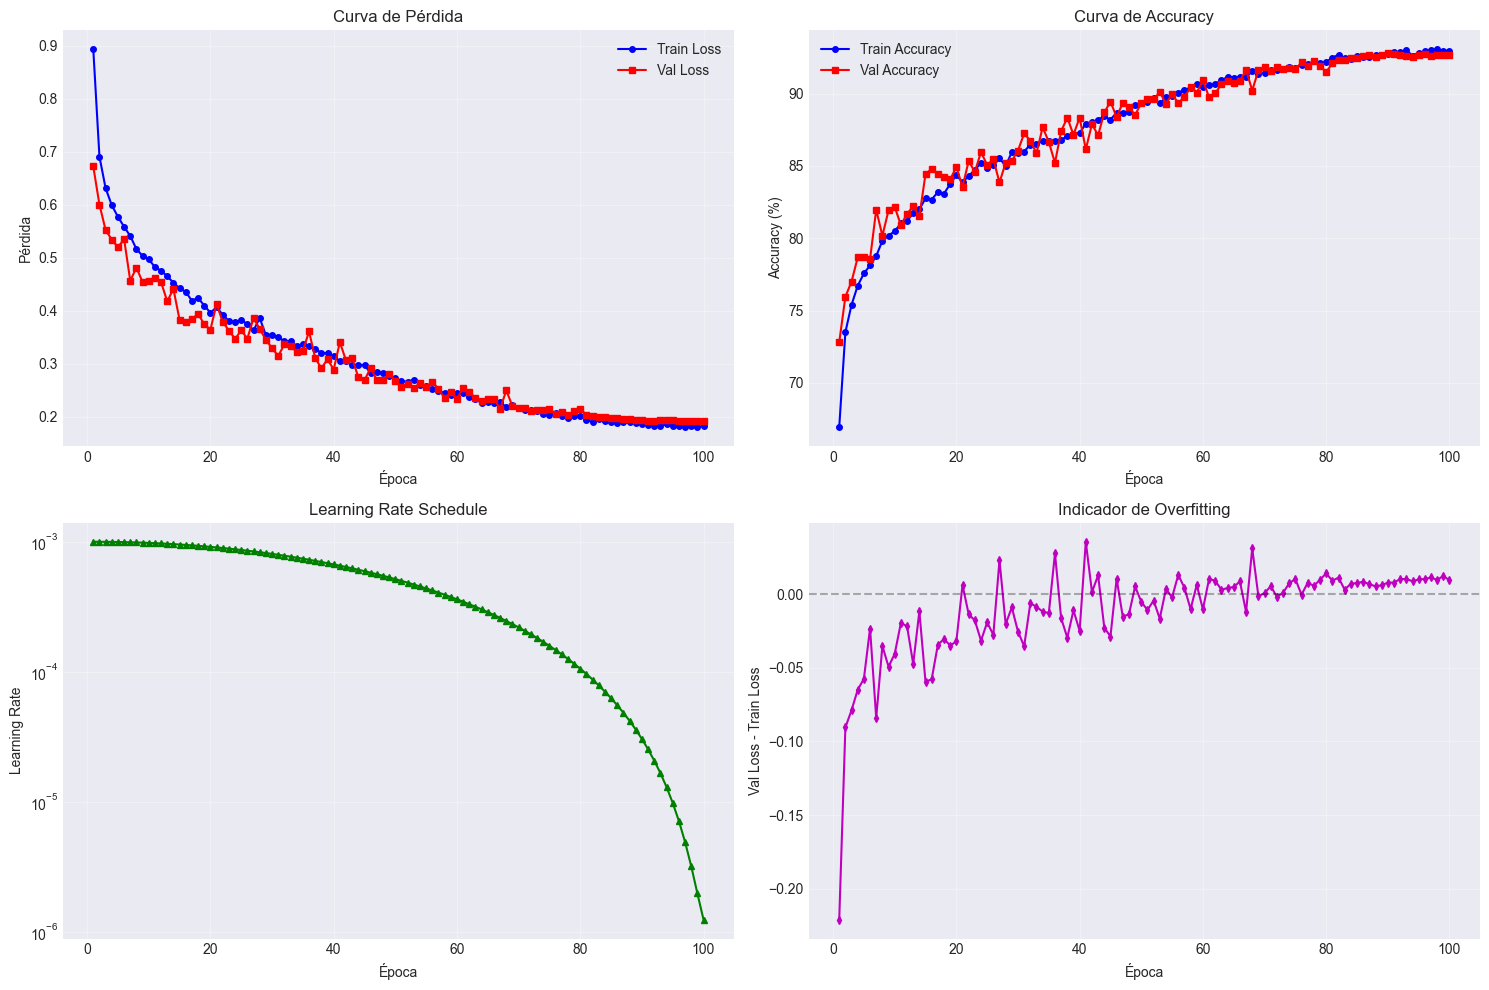

Curvas de aprendizaje guardadas en ../reports/learning_curves.png


In [11]:
# %% Celda 11: Visualizar curvas de aprendizaje
def plot_learning_curves(history):
    """Visualiza las curvas de aprendizaje"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Pérdida
    axes[0, 0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', markersize=4)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', markersize=4)
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Pérdida')
    axes[0, 0].set_title('Curva de Pérdida')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy', markersize=4)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-s', label='Val Accuracy', markersize=4)
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Curva de Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(epochs, history['learning_rates'], 'g-^', markersize=4)
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Diferencia Train-Val (Overfitting indicator)
    diff_loss = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 1].plot(epochs, diff_loss, 'm-d', markersize=4)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Val Loss - Train Loss')
    axes[1, 1].set_title('Indicador de Overfitting')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../reports/learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_learning_curves(history)
print("Curvas de aprendizaje guardadas en ../reports/learning_curves.png")

In [12]:
# %% Celda 12: Cargar mejor modelo para evaluación final
print("\n=== CARGANDO MEJOR MODELO ===")
checkpoint = torch.load('../models/best_lstm_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Mejor modelo cargado (Época {checkpoint['epoch']+1})")
print(f"Val Loss: {checkpoint['val_loss']:.4f}, Val Acc: {checkpoint['val_acc']:.2f}%")


=== CARGANDO MEJOR MODELO ===
Mejor modelo cargado (Época 98)
Val Loss: 0.1925, Val Acc: 92.65%


In [13]:
# %% Celda 13: Evaluación completa en Test Set
print("\n" + "="*70)
print("EVALUACIÓN EN TEST SET")
print("="*70)

test_loss, test_acc, test_preds, test_labels, test_probs = validate(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Métricas adicionales
balanced_acc = balanced_accuracy_score(test_labels, test_preds)
kappa = cohen_kappa_score(test_labels, test_preds)
mcc = matthews_corrcoef(test_labels, test_preds)

print(f"Balanced Accuracy: {balanced_acc*100:.2f}%")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Métricas por clase
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_preds, average=None, labels=range(len(le.classes_))
)

print("\n=== MÉTRICAS POR CLASE ===")
print(f"{'Clase':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for i, class_name in enumerate(le.classes_):
    print(f"{class_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} "
          f"{f1[i]:<12.4f} {support[i]:<10}")

# Promedios
print("\n=== PROMEDIOS ===")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1-Score (macro): {f1.mean():.4f}")

# Classification report completo
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(test_labels, test_preds, target_names=le.classes_))


EVALUACIÓN EN TEST SET

Test Loss: 0.1901
Test Accuracy: 92.52%
Balanced Accuracy: 91.79%
Cohen's Kappa: 0.9061
Matthews Correlation Coefficient: 0.9061

=== MÉTRICAS POR CLASE ===
Clase           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
pushups_down    0.8802       0.8949       0.8875       2036      
pushups_up      0.9103       0.8988       0.9045       1818      
situp_down      0.9790       0.9819       0.9805       1992      
situp_up        0.8892       0.8498       0.8690       406       
squats_down     0.9341       0.9527       0.9433       655       
squats_up       0.9346       0.9294       0.9320       2182      

=== PROMEDIOS ===
Precision (macro): 0.9212
Recall (macro): 0.9179
F1-Score (macro): 0.9195

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

pushups_down       0.88      0.89      0.89      2036
  pushups_up       0.91      0.90      0.90      181

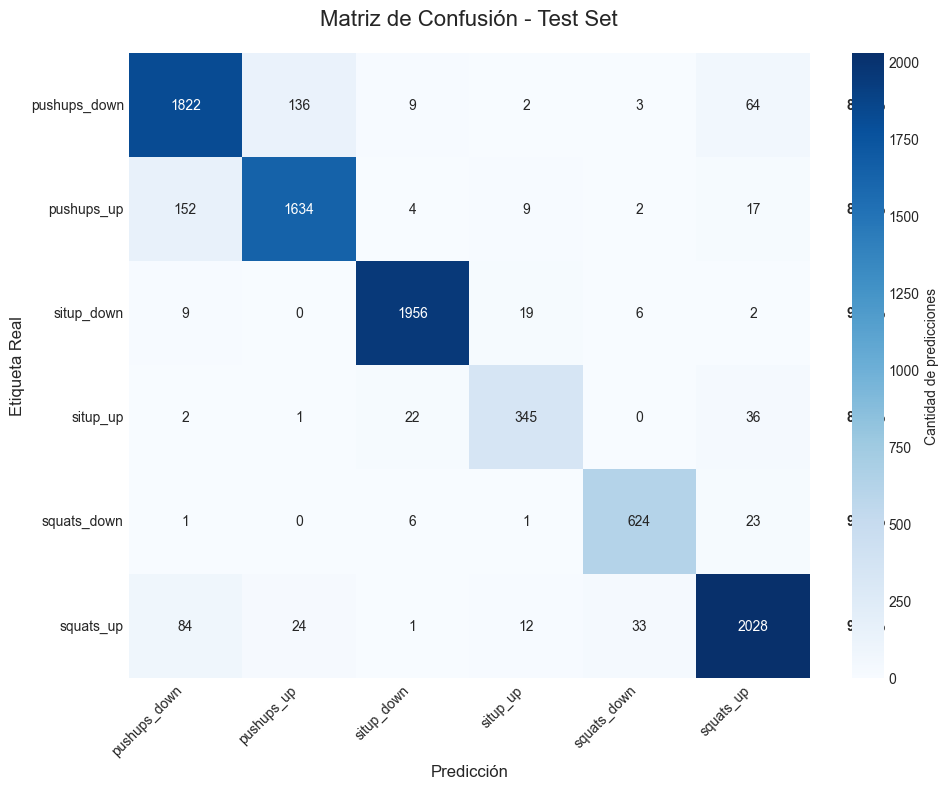

Matriz de confusión guardada en ../reports/confusion_matrix.png


In [14]:
# %% Celda 14: Matriz de Confusión
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Visualiza la matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Cantidad de predicciones'})
    
    plt.title('Matriz de Confusión - Test Set', fontsize=16, pad=20)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Predicción', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Calcular accuracy por clase
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i in range(len(class_names)):
        plt.text(len(class_names) + 0.5, i + 0.5, f'{cm_norm[i, i]*100:.1f}%',
                ha='center', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(test_labels, test_preds, le.classes_)
print("Matriz de confusión guardada en ../reports/confusion_matrix.png")

In [15]:
# %% Celda 15: Análisis de errores
print("\n=== ANÁLISIS DE ERRORES ===")

# Encontrar predicciones incorrectas
incorrect_indices = np.where(np.array(test_preds) != np.array(test_labels))[0]
print(f"Total de errores: {len(incorrect_indices)} de {len(test_labels)} "
      f"({len(incorrect_indices)/len(test_labels)*100:.2f}%)")

if len(incorrect_indices) > 0:
    print("\nPrimeros 10 errores:")
    print(f"{'Índice':<10} {'Real':<15} {'Predicho':<15} {'Confianza':<12}")
    print("-" * 60)
    for idx in incorrect_indices[:10]:
        real_class = le.classes_[test_labels[idx]]
        pred_class = le.classes_[test_preds[idx]]
        confidence = test_probs[idx][test_preds[idx]] * 100
        print(f"{idx:<10} {real_class:<15} {pred_class:<15} {confidence:<12.2f}%")
    
    # Pares de confusión más comunes
    from collections import Counter
    confusion_pairs = [(le.classes_[test_labels[i]], le.classes_[test_preds[i]]) 
                      for i in incorrect_indices]
    most_common = Counter(confusion_pairs).most_common(5)
    
    print("\nPares de confusión más comunes:")
    for (real, pred), count in most_common:
        print(f"  {real} → {pred}: {count} veces")


=== ANÁLISIS DE ERRORES ===
Total de errores: 680 de 9089 (7.48%)

Primeros 10 errores:
Índice     Real            Predicho        Confianza   
------------------------------------------------------------
6          squats_up       pushups_down    82.70       %
48         squats_up       pushups_down    77.68       %
78         pushups_up      pushups_down    85.81       %
82         squats_up       situp_up        60.84       %
108        pushups_up      pushups_down    99.25       %
115        pushups_up      pushups_down    63.96       %
124        squats_up       pushups_down    71.78       %
164        squats_up       pushups_down    61.98       %
172        squats_up       pushups_down    54.62       %
179        pushups_up      pushups_down    65.12       %

Pares de confusión más comunes:
  pushups_up → pushups_down: 152 veces
  pushups_down → pushups_up: 136 veces
  squats_up → pushups_down: 84 veces
  pushups_down → squats_up: 64 veces
  situp_up → squats_up: 36 veces


In [16]:
# %% Celda 16: Métricas de suavidad temporal
def calculate_smoothness(predictions):
    """Calcula la suavidad de las predicciones en el tiempo"""
    changes = np.sum(predictions[1:] != predictions[:-1])
    smoothness = 1 - (changes / (len(predictions) - 1))
    return smoothness, changes

smoothness, changes = calculate_smoothness(test_preds)
print(f"\n=== MÉTRICAS TEMPORALES ===")
print(f"Suavidad (Smoothness): {smoothness*100:.2f}%")
print(f"Cambios de predicción: {changes} de {len(test_preds)-1} transiciones")
print(f"Tasa de cambio: {changes/(len(test_preds)-1)*100:.2f}%")


=== MÉTRICAS TEMPORALES ===
Suavidad (Smoothness): 99.99%
Cambios de predicción: 1 de 9088 transiciones
Tasa de cambio: 0.01%


In [17]:
# %% Celda 17: Guardar resultados
print("\n=== GUARDANDO RESULTADOS ===")

# Guardar modelo final
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': le,
    'history': history,
    'test_metrics': {
        'accuracy': test_acc,
        'balanced_accuracy': balanced_acc,
        'cohen_kappa': kappa,
        'matthews_corrcoef': mcc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }
}, '../models/lstm_model_final.pth')

print("✅ Modelo final guardado en ../models/lstm_model_final.pth")

# Guardar predicciones
results_df = pd.DataFrame({
    'true_label': [le.classes_[i] for i in test_labels],
    'predicted_label': [le.classes_[i] for i in test_preds],
    'correct': np.array(test_preds) == np.array(test_labels)
})

# Añadir probabilidades por clase
for i, class_name in enumerate(le.classes_):
    results_df[f'prob_{class_name}'] = test_probs[:, i]

results_df.to_csv('../reports/test_predictions.csv', index=False)
print("✅ Predicciones guardadas en ../reports/test_predictions.csv")

# Guardar resumen de métricas
with open('../reports/metrics_summary.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("RESUMEN DE MÉTRICAS - MODELO LSTM\n")
    f.write("="*70 + "\n\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")
    f.write(f"Balanced Accuracy: {balanced_acc*100:.2f}%\n")
    f.write(f"Cohen's Kappa: {kappa:.4f}\n")
    f.write(f"Matthews Correlation Coefficient: {mcc:.4f}\n")
    f.write(f"Smoothness: {smoothness*100:.2f}%\n\n")
    f.write("Métricas por clase:\n")
    f.write(f"{'Clase':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}\n")
    f.write("-"*55 + "\n")
    for i, class_name in enumerate(le.classes_):
        f.write(f"{class_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f}\n")

print("✅ Resumen de métricas guardado en ../reports/metrics_summary.txt")

print("\n" + "="*70)
print("✅ PROCESO COMPLETADO EXITOSAMENTE")
print("="*70)


=== GUARDANDO RESULTADOS ===
✅ Modelo final guardado en ../models/lstm_model_final.pth
✅ Predicciones guardadas en ../reports/test_predictions.csv
✅ Resumen de métricas guardado en ../reports/metrics_summary.txt

✅ PROCESO COMPLETADO EXITOSAMENTE
